In [1]:
import xarray as xr
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
import cftime
from glob import glob
from typing import List
import json
sys.path.append('..')
sys.path.append('../modules')
import constants
import xarray_class_accessors as xca
import sn_plotting
import open_ds
import signal_to_noise as sn
import xarray_extender as xce
import xarray_class_accessors as xca
import sn_plotting
import warnings
warnings.filterwarnings('ignore')
import signal_to_noise as sn
import open_ds

In [2]:
constants.IMAGE_SAVE_DIR_INIT

'/home/563/ab2313/gdata/images/PhD/init'

# Paths

The code below can be used to ge the paths of all the files. However, this can be ery slow (3 hours) for piControl. 

In [3]:
# TODO: This should be a dict not a csv so you don't have to drop nans
fpaths_df = pd.read_csv('fpaths_picontrol.csv')[['picontrol', '1000pgc']]
fpaths_dict = fpaths_df.to_dict(orient='list')
fpaths_dict['1000pgc'] = [v for v in fpaths_dict['1000pgc'] if isinstance(v, str)]
fpaths_dict.keys()

dict_keys(['picontrol', '1000pgc'])

In [4]:
unique_picontrol_paths = np.unique(list(map(os.path.dirname, fpaths_dict['picontrol'])))
unique_picontrol_paths[:5]

array(['/g/data/oi10/replicas/CMIP6/CMIP/AS-RCEC/TaiESM1/piControl/r1i1p1f1/Amon/tas/gn/v20200211',
       '/g/data/oi10/replicas/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/piControl/r1i1p1f1/Amon/tas/gn/v20191015',
       '/g/data/oi10/replicas/CMIP6/CMIP/AWI/AWI-ESM-1-1-LR/piControl/r1i1p1f1/Amon/tas/gn/v20200212',
       '/g/data/oi10/replicas/CMIP6/CMIP/BCC/BCC-CSM2-MR/esm-piControl/r1i1p1f1/Amon/tas/gn/v20181114',
       '/g/data/oi10/replicas/CMIP6/CMIP/BCC/BCC-CSM2-MR/piControl/r1i1p1f1/Amon/tas/gn/v20181016'],
      dtype='<U111')

In [5]:
# Unique abspath (no filename).
unique_1000PgC_paths = np.unique(list(map(os.path.dirname,fpaths_dict['1000pgc'])))
# Removing all precipitation files.
base_fpaths_1000PgC = np.sort([f for f in unique_1000PgC_paths if '/tas/' in f]).tolist()
base_fpaths_1000PgC[:5]

['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429',
 '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r2i1p2f1/Amon/tas/gn/v20190429',
 '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r3i1p2f1/Amon/tas/gn/v20190429',
 '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r4i1p2f1/Amon/tas/gn/v20190429',
 '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r5i1p2f1/Amon/tas/gn/v20190429']

In [6]:
# These are all of the base models - models may have different experminents (r1i1p2f1, r2i1p2f1)
base_group = np.unique(['/'.join(f.split('/')[:10])  for f in base_fpaths_1000PgC])
base_group

array(['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC',
       '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC',
       '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC',
       '/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC',
       '/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC',
       '/g/data/oi10/replicas/CMIP6/C4MIP/NCAR/CESM2/esm-1pct-brch-1000PgC',
       '/g/data/oi10/replicas/CMIP6/C4MIP/NCC/NorESM2-LM/esm-1pct-brch-1000PgC',
       '/g/data/oi10/replicas/CMIP6/C4MIP/NOAA-GFDL/GFDL-ESM4/esm-1pct-brch-1000PgC'],
      dtype='<U80')

In [7]:
# Get one experiment for each modelling group
needed_experiments = []
# Looping through all the base paths
for base_group_single in base_group:
    
    # All the experiments that have this base path
    experiments = [f for f in base_fpaths_1000PgC if base_group_single in f]
    # Get just the first one available
    needed_experiments.append(experiments[0])
    
needed_experiments

['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NCAR/CESM2/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191119',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NCC/NorESM2-LM/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191108',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NOAA-GFDL/GFDL-ESM4/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gr1/v20180701']

In [8]:
needed_model_dict = {v.split('/')[8]:v for v in needed_experiments}
needed_model_dict

{'CanESM5': '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429',
 'MIROC-ES2L': '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622',
 'UKESM1-0-LL': '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210',
 'MPI-ESM1-2-LR': '/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815',
 'GISS-E2-1-G-CC': '/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202',
 'CESM2': '/g/data/oi10/replicas/CMIP6/C4MIP/NCAR/CESM2/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191119',
 'NorESM2-LM': '/g/data/oi10/replicas/CMIP6/C4MIP/NCC/NorESM2-LM/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191108',
 'GFDL-ESM4': '/g/data/oi10/replicas/CMIP6/C4MIP/NOAA-GFDL/GFDL-ESM4/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gr1/v20180701'}

In [9]:
zecmip_path_dict = {'1000pgc': {'all': unique_1000PgC_paths.tolist(), 'needed': needed_model_dict}
                    , 'picontrol': unique_picontrol_paths.tolist()}
zecmip_path_dict.keys()

dict_keys(['1000pgc', 'picontrol'])

In [10]:
with open('zecmip_model_paths.json', 'w') as f:
    json.dump(zecmip_path_dict, f)

# Opening All Models

In [36]:
needed_experiments

['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NCAR/CESM2/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191119',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NCC/NorESM2-LM/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191108',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NOAA-GFDL/GFDL-ESM4/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gr1/v20180701']

In [37]:
unique_picontrol_paths[:5]

array(['/g/data/oi10/replicas/CMIP6/CMIP/AS-RCEC/TaiESM1/piControl/r1i1p1f1/Amon/tas/gn/v20200211',
       '/g/data/oi10/replicas/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/piControl/r1i1p1f1/Amon/tas/gn/v20191015',
       '/g/data/oi10/replicas/CMIP6/CMIP/AWI/AWI-ESM-1-1-LR/piControl/r1i1p1f1/Amon/tas/gn/v20200212',
       '/g/data/oi10/replicas/CMIP6/CMIP/BCC/BCC-CSM2-MR/esm-piControl/r1i1p1f1/Amon/tas/gn/v20181114',
       '/g/data/oi10/replicas/CMIP6/CMIP/BCC/BCC-CSM2-MR/piControl/r1i1p1f1/Amon/tas/gn/v20181016'],
      dtype='<U111')

In [38]:
reload(open_ds)
fpath = needed_experiments[1]
print( '\n'+ fpath)
experiment_ds = xr.open_mfdataset(os.path.join(fpath, '*.nc'))
experiment_ds = open_ds.correct_dataset(experiment_ds).tas


/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622
Converting from numpy to cftime
Dataset ranges between 1913-01-16 12:00:00 and 2160-12-16 12:00:00
New time dim will range between 0001-01-01 00:00:00 and 0248-11-30 00:00:00
Old time values
['1913-01-16T12:00:00.000000000' '1913-02-15T00:00:00.000000000'
 '1913-03-16T12:00:00.000000000' '1913-04-16T00:00:00.000000000'
 '1913-05-16T12:00:00.000000000']
['2160-08-16T12:00:00.000000000' '2160-09-16T00:00:00.000000000'
 '2160-10-16T12:00:00.000000000' '2160-11-16T00:00:00.000000000'
 '2160-12-16T12:00:00.000000000']
New time values
CFTimeIndex([0001-01-01 00:00:00, 0001-01-31 10:29:14.621849, 0001-03-02 20:58:29.243697,
             0001-04-02 07:27:43.865546],
            dtype='object',
            length=4,
            calendar='standard',
            freq='2629754621848U')
CFTimeIndex([0248-08-30 16:32:16.134455, 0248-09-30 03:01:30.756303, 0248-10-30 13:30:45.378152,
             

In [39]:
reload(open_ds)

to_merge = []
for fpath in needed_experiments:
    print( '\n'+ fpath)
    experiment_da = xr.open_mfdataset(os.path.join(fpath, '*.nc'))
    experiment_da = open_ds.correct_dataset(experiment_da).tas
    # Renaming the dataset to the name of the model
    experiment_da.name = fpath.split('/')[7].lower().replace('-','_')
    to_merge.append(experiment_da)


/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429
Dataset ranges between 1911-01-16 12:00:00 and 2010-12-16 12:00:00
New time dim will range between 0001-01-01 00:00:00 and 0100-11-06 00:00:00
Old time values
[cftime.DatetimeNoLeap(1911, 1, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1911, 2, 15, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1911, 3, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1911, 4, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1911, 5, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(2010, 8, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2010, 9, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2010, 10, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2010, 11, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2010, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
New time values
CFTimeIndex([0001-01-01 00:00:00



\Data correction successfull. New dataset
<xarray.Dataset>
Dimensions:   (time: 180, lat: 90, bnds: 2, lon: 144)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 0180-12-31 00:00:00
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
    height    float64 2.0
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    tas       (time, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>

/g/data/oi10/replicas/CMIP6/C4MIP/NCAR/CESM2/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191119
Dataset ranges between 0068-01-15 12:00:00 and 0217-12-15 12:00:00
New time dim will range between 0001-01-01 00:00:00 and 0150-10-25 00:00:00
Old time values
[cftime.DatetimeNoLeap(68, 1, 15, 12, 0

In [40]:
# Mering all the expirments into one ds. Compat='override' is needed as there
# are multiple different height dimes used, however, hieght is not needed.
experiment_ds = xr.merge(to_merge, compat='override')
experiment_ds

<xarray.Dataset>
Dimensions:    (time: 326, lat: 924, lon: 777)
Coordinates:
  * time       (time) object 0001-12-31 00:00:00 ... 0326-12-31 00:00:00
  * lat        (lat) float64 -90.0 -89.5 -89.38 -89.06 ... 89.06 89.38 89.5 90.0
  * lon        (lon) float64 0.0 0.625 0.9375 1.25 ... 358.1 358.8 359.1 359.4
    height     float64 ...
Data variables:
    cccma      (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    miroc      (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    mohc       (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    mpi_m      (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    nasa_giss  (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    ncar       (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    ncc        (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    noaa_gfdl  (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>

In [41]:
reload(open_ds)

to_merge_pi = []
for fpath in needed_experiments:
    print( '\n'+ fpath)
    picontrol_da = open_ds.open_matching_picontrol(fpath, unique_picontrol_paths)

    picontrol_da = open_ds.correct_dataset(picontrol_da).tas
    # Renaming the dataset to the name of the model
    picontrol_da.name = fpath.split('/')[7].lower().replace('-','_')
    to_merge_pi.append(picontrol_da)



/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429
Attempting to open matching pic control for
/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429
Searching for branch containing
CCCma/CanESM5/esm-piControl/r1i1p2f1/Amon/tas
Opening all datasets in location
Dataset ranges between 0001-01-17 00:00:00 and 0500-12-17 00:00:00
New time dim will range between 0001-01-01 00:00:00 and 0500-07-29 00:00:00
Old time values
[cftime.DatetimeNoLeap(1, 1, 17, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 2, 15, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 3, 17, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 4, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 5, 17, 0, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(500, 8, 17, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(500, 9, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLe



\Data correction successfull. New dataset
<xarray.Dataset>
Dimensions:   (time: 500, lat: 96, bnds: 2, lon: 192)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 0500-12-31 00:00:00
  * lat       (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height    float64 2.0
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(1, 96, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(1, 192, 2), meta=np.ndarray>
    tas       (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>

/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202
Attempting to open matching pic control for
/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202
Searching for branch c

Dataset ranges between 0001-01-16 12:00:00 and 0500-12-16 12:00:00
New time dim will range between 0001-01-01 00:00:00 and 0500-07-29 00:00:00
Old time values
[cftime.DatetimeNoLeap(1, 1, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 2, 15, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 3, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 4, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 5, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(500, 8, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(500, 9, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(500, 10, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(500, 11, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(500, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
New time values
CFTimeIndex([0001-01-01 00:00:00, 0001-01-31 09:59:51.598600, 0001-03-02 19:59:43.197200,
             0001-04-02 05:59:34.795799],
            dtype='obj

In [42]:
# Mering all the expirments into one ds. Compat='override' is needed as there
# are multiple different height dimes used, however, hieght is not needed.
picontrol_ds = xr.merge(to_merge_pi, compat='override')
picontrol_ds

<xarray.Dataset>
Dimensions:    (time: 500, lon: 777, lat: 850)
Coordinates:
  * time       (time) object 0001-12-31 00:00:00 ... 0500-12-31 00:00:00
  * lon        (lon) float64 0.0 0.625 0.9375 1.25 ... 358.1 358.8 359.1 359.4
  * lat        (lat) float64 -90.0 -89.5 -89.38 -89.06 ... 89.06 89.38 89.5 90.0
    height     float64 2.0
Data variables:
    cccma      (time, lat, lon) float32 dask.array<chunksize=(1, 850, 777), meta=np.ndarray>
    miroc      (time, lat, lon) float32 dask.array<chunksize=(1, 850, 777), meta=np.ndarray>
    mohc       (time, lat, lon) float32 dask.array<chunksize=(1, 850, 777), meta=np.ndarray>
    mpi_m      (time, lat, lon) float32 dask.array<chunksize=(1, 850, 777), meta=np.ndarray>
    nasa_giss  (time, lat, lon) float32 dask.array<chunksize=(1, 850, 777), meta=np.ndarray>
    ncar       (time, lat, lon) float32 dask.array<chunksize=(1, 850, 777), meta=np.ndarray>
    ncc        (time, lat, lon) float32 dask.array<chunksize=(1, 850, 777), meta=np.ndarray>
    noaa_gfdl  (time, lat, lon) float32 dask.array<chunksize=(1, 850, 777), meta=np.ndarray>

In [43]:
list(experiment_ds.data_vars)

['cccma', 'miroc', 'mohc', 'mpi_m', 'nasa_giss', 'ncar', 'ncc', 'noaa_gfdl']

In [44]:
list(picontrol_ds.data_vars)

['cccma', 'miroc', 'mohc', 'mpi_m', 'nasa_giss', 'ncar', 'ncc', 'noaa_gfdl']

# Signal To Noise

In [45]:
experiment_ds

<xarray.Dataset>
Dimensions:    (time: 326, lat: 924, lon: 777)
Coordinates:
  * time       (time) object 0001-12-31 00:00:00 ... 0326-12-31 00:00:00
  * lat        (lat) float64 -90.0 -89.5 -89.38 -89.06 ... 89.06 89.38 89.5 90.0
  * lon        (lon) float64 0.0 0.625 0.9375 1.25 ... 358.1 358.8 359.1 359.4
    height     float64 ...
Data variables:
    cccma      (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    miroc      (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    mohc       (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    mpi_m      (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    nasa_giss  (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    ncar       (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    ncc        (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>
    noaa_gfdl  (time, lat, lon) float32 dask.array<chunksize=(1, 924, 777), meta=np.ndarray>

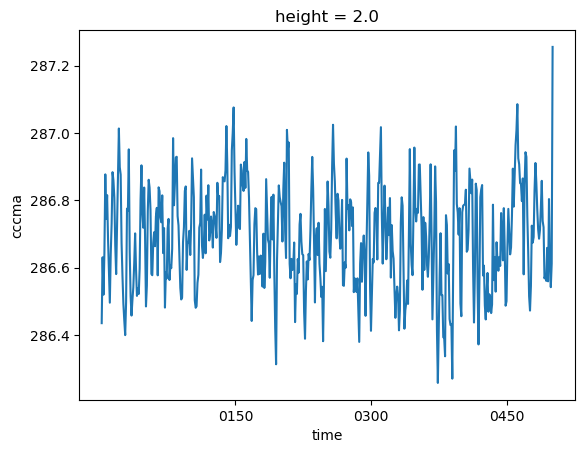

In [46]:
picontrol_ds['cccma'].clima.space_mean().plot()

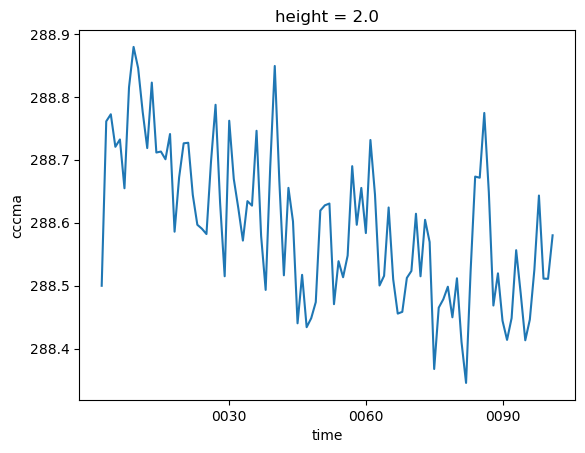

In [47]:
experiment_ds['cccma'].clima.space_mean().plot()

In [48]:
reload(xca)

<module 'xarray_class_accessors' from '/home/563/ab2313/Documents/PhD/zec_mip/../modules/xarray_class_accessors.py'>

In [49]:
experiment_ds_anom = experiment_ds.clima_ds.anomalies(picontrol_ds)


cccma, Using historical dataset
miroc, Using historical dataset
mohc, Using historical dataset
mpi_m, Using historical dataset
nasa_giss, Using historical dataset
ncar, Using historical dataset
ncc, Using historical dataset
noaa_gfdl, Using historical dataset


In [50]:
picontrol_ds_smean = picontrol_ds.clima_ds.space_mean().load()

In [51]:
experiment_ds_smean = experiment_ds_anom.clima_ds.space_mean().load()

In [52]:
experiment_ds_smean

<xarray.Dataset>
Dimensions:    (time: 326)
Coordinates:
  * time       (time) object 0001-12-31 00:00:00 ... 0326-12-31 00:00:00
    height     float64 2.0
Data variables:
    cccma      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    miroc      (time) float64 1.307 1.416 1.611 1.495 1.624 ... nan nan nan nan
    mohc       (time) float64 2.548 2.851 2.807 2.889 ... 3.166 3.122 2.518
    mpi_m      (time) float64 1.475 1.542 1.621 1.389 1.9 ... nan nan nan nan
    nasa_giss  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ncar       (time) float64 1.72 2.019 1.939 1.816 2.051 ... nan nan nan nan
    ncc        (time) float64 1.258 1.226 1.226 1.552 1.45 ... nan nan nan nan
    noaa_gfdl  (time) float64 1.19 1.442 1.485 1.436 1.299 ... nan nan nan nan

FileNotFoundError: [Errno 2] No such file or directory: '/home/563/ab2313/Documents/images/PhD/init/multi_model_picontrol_zec.png'

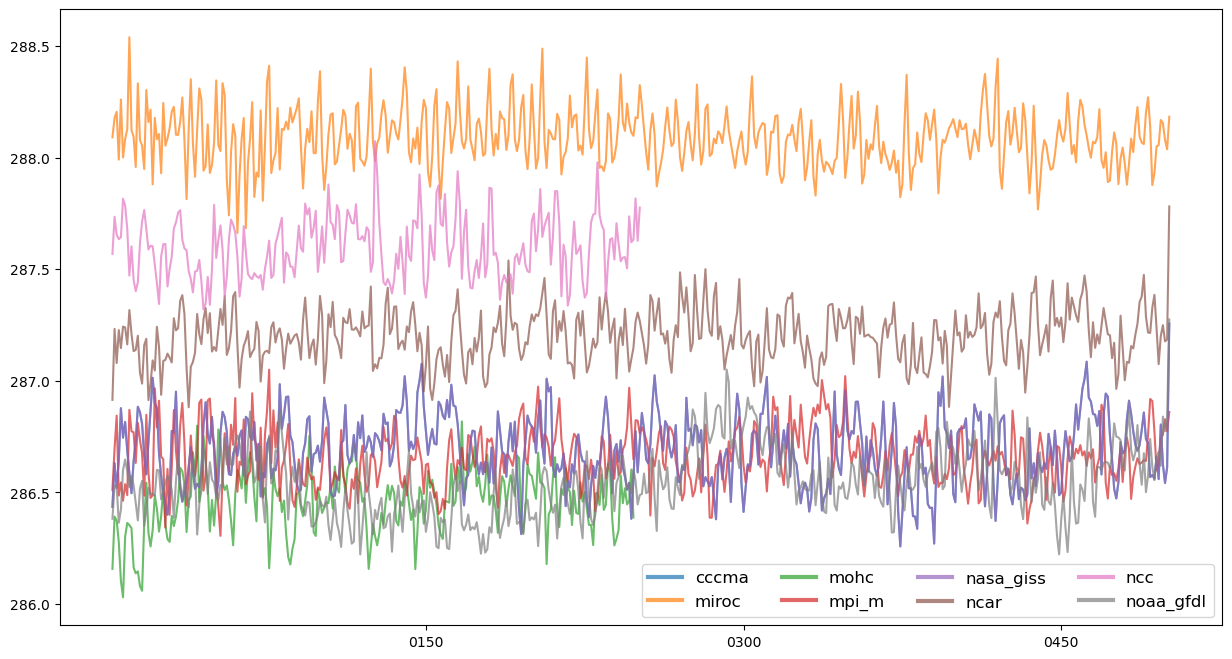

In [53]:
fig, ax = plt.subplots(figsize=(15,8))

time = picontrol_ds_smean['time'].values
for var in list(picontrol_ds_smean.data_vars):
    if var =='mean':
        plot_kwargs = dict(alpha=1, c='k', zorder=-100)

    else:
        plot_kwargs = dict(linestyle='-', alpha=0.7)
        
    ax.plot(time, picontrol_ds_smean[var].values, label=var, **plot_kwargs)
    
leg = ax.legend(ncol = 4, fontsize=12)
[line.set_linewidth(3) for line in leg.get_lines()];
fig.savefig('piControl')
fig.savefig(os.path.join(IMG_DIR, 'multi_model_picontrol_zec.png'), bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

time = experiment_ds_smean['time'].values
for var in list(experiment_ds_smean.data_vars):
    if var =='mean':
        plot_kwargs = dict(alpha=1, c='k', zorder=-100)

    else:
        plot_kwargs = dict(linestyle='-', alpha=0.7)
        
    ax.plot(time, experiment_ds_smean[var].values, label=var, **plot_kwargs)
    
leg = ax.legend(ncol = 4, fontsize=12)
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title('multi_model_1000PgC')
ax.set_ylabel('temp anomaly')
fig.savefig(os.path.join(IMG_DIR, 'multi_model_1000PgC.png'), bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(15,25))

time = experiment_ds_smean['time'].values
data_vars = list(experiment_ds_smean.data_vars)
for i,dvar in enumerate(data_vars):
    ax = fig.add_subplot(len(data_vars),1, i+1)

    plot_kwargs = dict(linestyle='-', alpha=0.7)
        
    ax.plot(time, experiment_ds_smean[dvar].values, label=dvar, **plot_kwargs)
    ax.set_title(dvar)
    ax.set_ylabel('temp anomaly')
    
# leg = ax.legend(ncol = 4, fontsize=12)
# [line.set_linewidth(3) for line in leg.get_lines()];

# fig.savefig(os.path.join(IMG_DIR, 'multi_model_1000PgC.png'), bbox_inches='tight')

# Signal to Noise

In [ ]:
reload(xca)

In [ ]:
reload(sn)

In [ ]:
end_window = 60

In [ ]:
experiment_ds_smean

In [ ]:
# Dropping shorter (ncc) or runs with errors (nasa_giss, cccma)
experiment_ds_smean = experiment_ds_smean.drop(['ncc', 'nasa_giss', 'cccma'], errors='ignore')

In [ ]:
stable_sn_ds, unstable_sn_ds = experiment_ds_smean.clima_ds.sn_multiwindow(picontrol_ds_smean,
                                                                           start_window = 10, 
                                                                           end_window = end_window,
                                                                           step_window = 2)
#                                                                            ,logginglevel='DEBUG')

In [ ]:
stable_sn_ds

In [ ]:
unstable_sn_ds

In [ ]:
# Counting the number of models present at each time step.
number_models_present = sn.count_over_data_vars(experiment_ds_smean, list(unstable_sn_ds.data_vars), dim='model')
number_models_present

In [ ]:
number_models_present.plot()

In [ ]:
# Gettting the percent of models that are stable at each point
reload(sn)
unstable_frac_da = sn.percent_finite(unstable_sn_ds, number_models_present)
stable_frac_da = sn.percent_finite(stable_sn_ds, number_models_present)
unstable_frac_da

In [ ]:
experiment_ds_smean

In [ ]:
models = list(experiment_ds_smean.data_vars)

In [ ]:
cbar_xticklabels = np.arange(len(models) + 1)
step = 100/(len(models))

cbar_xticklabels

In [ ]:
end_window

In [ ]:
reload(sn_plotting)

In [ ]:
for a in list(experiment_ds_smean['noaa_gfdl'].to_dataset().data_vars):
    print(a)

In [ ]:
reload(sn_plotting)

In [ ]:
fig, ax1, ax2, ax3, cbar = sn_plotting.sn_multi_window_in_time(unstable_frac_da, stable_frac_da,
                                                               experiment_ds_smean, 
                                # TODO: vmax should not need to have step added. 
                               vmin=0, vmax=100 + step, step=step, 
                                cmap='Blues', extend='neither', xupperlim=100
                                , cbar_xticklabels = cbar_xticklabels, cbartick_offset=step/2,
                               cbar_label= 'Number of Unstable Models', 
                                title = f'ZEC models {models}')
ax1.set_ylim([10,50])

fig.savefig(f'{IMG_DIR}/zecmip_SN_multi_window_frac_unstable', dpi=400, bbox_inches='tight')

In [ ]:
unstable_sn_ds

In [ ]:
print(sn_plotting.sn_multi_window_in_time.__doc__)

In [ ]:
stable_sn_ds[model].dropna(dim='time')

In [ ]:
# Looping through all the models in our resultant dicionary and printing the result. 
for model in list(unstable_sn_ds.data_vars):
    print(model)
    
    unstable_da = unstable_sn_ds[model]#.dropna(dim='time')
    stable_da = stable_sn_ds[model].dropna(dim='time')
    experiment_da = experiment_ds_smean[model].dropna(dim='time')
    
    sn_plotting.sn_multi_window_in_time(unstable_da, stable_da,experiment_da, 
                                        title=model, step=1);

    fig.savefig(f'{IMG_DIR}/zecmip_{model}_SN_multi_window.png', dpi=400, bbox_inches='tight')